In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np

In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
tme_test_stakeoff
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200325
partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)

dataset = "tme_test_stakeoff"
table = "tme_stakeoff_test_{0}".format(partition)

tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

window_min = 131130
window_max = 131180

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
SELECT 
  MAX(T.jsonPayload.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
WHERE
   T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}' and
   T.jsonPayload.number >= {window_min} and
   T.jsonPayload.number <= {window_max}
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks['blocktime'] = df_blocks[::-1].diff(axis=0).timestamp
df_blocks = df_blocks
df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,5.100000e+01,51.000000,51.000000,51.0,51.000000,50.0
mean,1.579358e+09,131155.000000,139552.294118,20000000.0,1.019608,5.0
std,7.433034e+01,14.866069,82359.270812,0.0,0.140028,0.0
min,1.579358e+09,131130.000000,29363.000000,20000000.0,1.000000,5.0
25%,1.579358e+09,131142.500000,91069.000000,20000000.0,1.000000,5.0
50%,1.579358e+09,131155.000000,120432.000000,20000000.0,1.000000,5.0
75%,1.579358e+09,131167.500000,171819.500000,20000000.0,1.000000,5.0
max,1.579358e+09,131180.000000,476676.000000,20000000.0,2.000000,5.0


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.579358e+09,131180.0,82138.0,20000000.0,1,5.0
1,1.579358e+09,131179.0,120432.0,20000000.0,1,5.0
2,1.579358e+09,131178.0,99795.0,20000000.0,1,5.0
3,1.579358e+09,131177.0,91069.0,20000000.0,1,5.0
4,1.579358e+09,131176.0,120432.0,20000000.0,2,5.0


last block  : 131180 on 1579358032.0
first block : 131130 on 1579357782.0
blocks load : 51
transactions: 52
mean gasUsed: 139552 GcWei
mean blocktime: 5 s


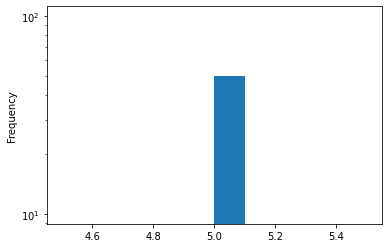

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.0f} s")

In [8]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.values.rewardsamount,
  jsonPayload.values.rewardsmultiplier,
  jsonPayload.values.medianRate,
  jsonPayload.values.currentStableBucket,
  jsonPayload.values.currentGoldBucket,
  jsonPayload.values.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}' and
  jsonPayload.blockNumber >= {window_min} and
  jsonPayload.blockNumber <= {window_max}
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state = df_state \
    .groupby('blockNumber').max() \
    .merge(df_blocks, left_on='blockNumber', right_on='blockNumber', suffixes=('_tme', '_block'))
df_state['datetime_block'] = pd.to_datetime(df_state['timestamp_block'],unit='s')
df_state[['currentStableBucket','currentGoldBucket']] = df_state[['currentStableBucket','currentGoldBucket']].astype('float')

df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,51.000000,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.0,51.000000,50.0
mean,131155.000000,6.002791e+26,1.614591e+24,9.990000e-01,9.977415e+23,9.983509e+23,1.089266e+26,1.579358e+09,139552.294118,20000000.0,1.019608,5.0
std,14.866069,3.142666e+19,8.763084e+16,1.121270e-16,3.141791e+20,3.064497e+20,1.735082e+10,7.433034e+01,82359.270812,0.0,0.140028,0.0
min,131130.000000,6.002790e+26,1.614591e+24,9.990000e-01,9.975453e+23,9.975588e+23,1.089266e+26,1.579358e+09,29363.000000,20000000.0,1.000000,5.0
25%,131142.500000,6.002790e+26,1.614591e+24,9.990000e-01,9.975453e+23,9.983473e+23,1.089266e+26,1.579358e+09,91069.000000,20000000.0,1.000000,5.0
50%,131155.000000,6.002791e+26,1.614591e+24,9.990000e-01,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,120432.000000,20000000.0,1.000000,5.0
75%,131167.500000,6.002791e+26,1.614591e+24,9.990000e-01,9.977427e+23,9.985439e+23,1.089266e+26,1.579358e+09,171819.500000,20000000.0,1.000000,5.0
max,131180.000000,6.002791e+26,1.614591e+24,9.990000e-01,9.985553e+23,9.985439e+23,1.089266e+26,1.579358e+09,476676.000000,20000000.0,2.000000,5.0


In [9]:
df_state.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
46,131176.0,2020-03-26 08:35:26.691864+00:00,6.002791e+26,1.614591e+24,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,120432.0,20000000.0,2,5.0,2020-01-18 14:33:32
47,131177.0,2020-03-26 08:35:27.299302+00:00,6.002791e+26,1.614591e+24,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,91069.0,20000000.0,1,5.0,2020-01-18 14:33:37
48,131178.0,2020-03-26 08:35:27.749818+00:00,6.002791e+26,1.614591e+24,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,99795.0,20000000.0,1,5.0,2020-01-18 14:33:42
49,131179.0,2020-03-26 08:35:28.500620+00:00,6.002791e+26,1.614591e+24,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,120432.0,20000000.0,1,5.0,2020-01-18 14:33:47
50,131180.0,2020-03-26 08:35:29.105166+00:00,6.002791e+26,1.614591e+24,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,82138.0,20000000.0,1,5.0,2020-01-18 14:33:52


Text(0, 0.5, 'SortedOracles.medianRate')

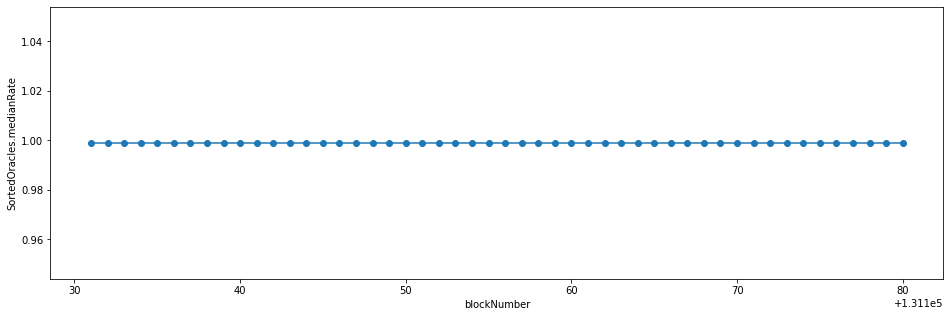

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]
df_slice = df_state[1:]
df_sortedOracles = df_slice.set_index('blockNumber')['medianRate']
ax = df_sortedOracles.plot(marker='o')
ax.set_ylabel("SortedOracles.medianRate")

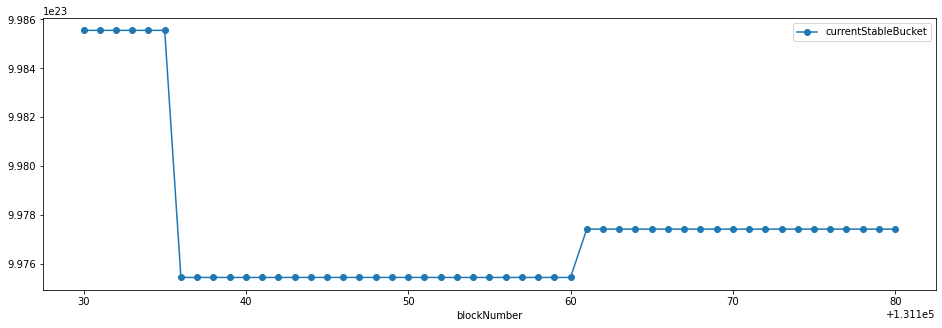

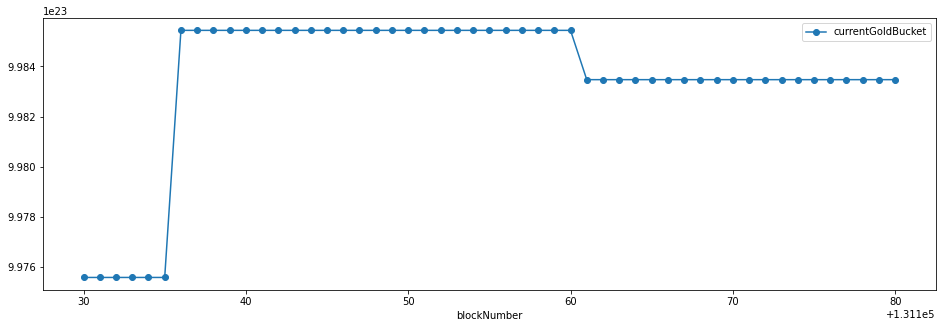

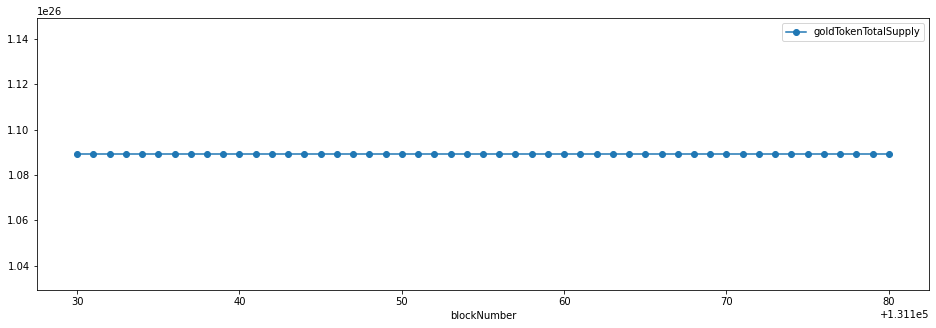

In [11]:
df_stableToken = df_state.set_index('blockNumber')[['currentStableBucket']]
df_stableToken.plot(marker='o')
# df_stableToken[df_stableToken<2e24].plot(marker='o')
df_goldbucket = df_state.set_index('blockNumber')[['currentGoldBucket']]
df_goldbucket.plot(marker='o')
df_goldToken = df_state.set_index('blockNumber')[['goldTokenTotalSupply']]
ax = df_goldToken.plot(marker='o')

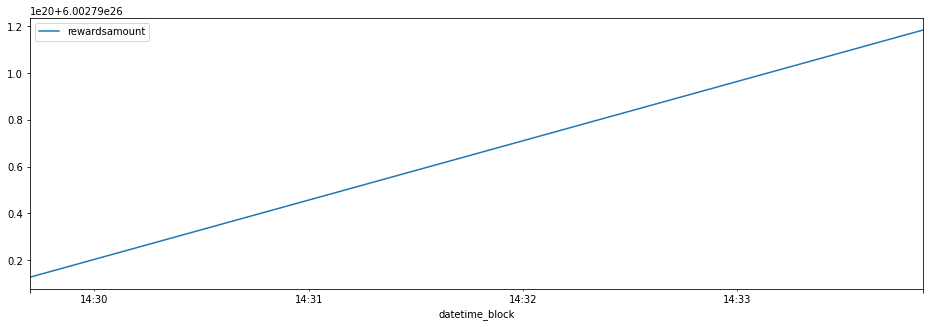

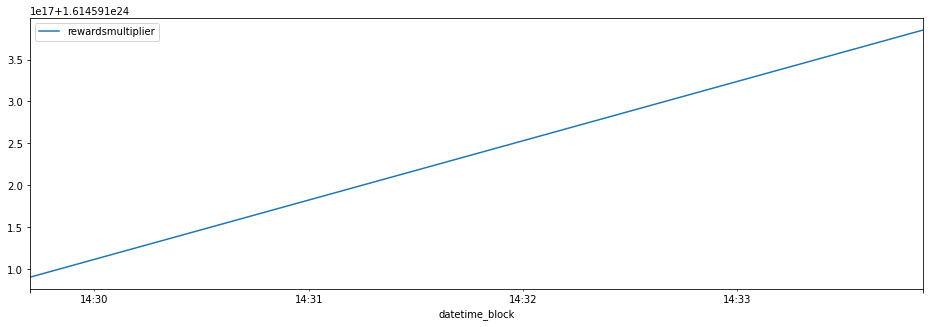

In [12]:
df_rewardsAmount = df_state.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df_state.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()

In [13]:
query_events = f"""
SELECT
  jsonPayload.blockNumber as blockNumber,
  jsonPayload.returnValues,
  jsonPayload.address,
  jsonPayload.eventName
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_PARSED_LOG.value}' and
  jsonPayload.blockNumber >= {window_min} and
  jsonPayload.blockNumber <= {window_max}
ORDER BY 
  blockNumber DESC
"""

df_events = client.query(
    query_events, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_events = pd.concat([
    df_events.drop(['returnValues'], axis=1), 
    df_events['returnValues'].apply(pd.Series)
], axis=1)

df_events[['buyamount','sellamount']] = df_events[['buyamount','sellamount']].astype('float')
df_events = df_events.merge(df_state, left_on='blockNumber', right_on='blockNumber')
df_events.describe()

,blockNumber,sellamount,buyamount,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,112.000000,1.000000e+00,1.000000e+00,1.120000e+02,1.120000e+02,1.120000e+02,1.120000e+02,1.120000e+02,1.120000e+02,1.120000e+02,112.000000,112.0,112.000000,110.0
mean,131155.625000,1.973901e+20,1.965610e+20,6.002791e+26,1.614591e+24,9.990000e-01,9.977364e+23,9.983558e+23,1.089266e+26,1.579358e+09,159283.294643,20000000.0,1.035714,5.0
std,14.664491,NaN,NaN,3.100053e+19,8.644260e+16,2.230426e-16,2.999004e+20,2.925533e+20,1.725708e+10,7.332246e+01,83367.658979,0.0,0.186411,0.0
min,131130.000000,1.973901e+20,1.965610e+20,6.002790e+26,1.614591e+24,9.990000e-01,9.975453e+23,9.975588e+23,1.089266e+26,1.579358e+09,29363.000000,20000000.0,1.000000,5.0
25%,131143.000000,1.973901e+20,1.965610e+20,6.002790e+26,1.614591e+24,9.990000e-01,9.975453e+23,9.983473e+23,1.089266e+26,1.579358e+09,111501.000000,20000000.0,1.000000,5.0
50%,131156.500000,1.973901e+20,1.965610e+20,6.002791e+26,1.614591e+24,9.990000e-01,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,138089.000000,20000000.0,1.000000,5.0
75%,131168.000000,1.973901e+20,1.965610e+20,6.002791e+26,1.614591e+24,9.990000e-01,9.977427e+23,9.985439e+23,1.089266e+26,1.579358e+09,199795.000000,20000000.0,1.000000,5.0
max,131180.000000,1.973901e+20,1.965610e+20,6.002791e+26,1.614591e+24,9.990000e-01,9.985553e+23,9.985439e+23,1.089266e+26,1.579358e+09,476676.000000,20000000.0,2.000000,5.0


In [14]:
df_events.head()

,blockNumber,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,metadataurl,value,...,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
0,131180.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,82138.0,20000000.0,1,5.0,2020-01-18 14:33:52
1,131180.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,82138.0,20000000.0,1,5.0,2020-01-18 14:33:52
2,131179.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,10000,...,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,120432.0,20000000.0,1,5.0,2020-01-18 14:33:47
3,131179.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,120432.0,20000000.0,1,5.0,2020-01-18 14:33:47
4,131178.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,10000,...,0.999,9.977427e+23,9.983473e+23,1.089266e+26,1.579358e+09,99795.0,20000000.0,1,5.0,2020-01-18 14:33:42


In [15]:
df_events.groupby('eventName').eventName.count().sort_values(ascending=False)

eventName
Transfer     110
Exchanged      1
Approval       1
Name: eventName, dtype: int64

In [16]:
df_exchange = df_events[df_events.eventName == "Exchanged"].set_index('blockNumber')[['exchanger', 'buyamount', 'sellamount', 'soldgold']]
df_exchange.groupby('exchanger').exchanger.count().sort_values(ascending=False)

exchanger
0x060b52F506579625aD73b99f1bE8D6B06259953D    1
Name: exchanger, dtype: int64

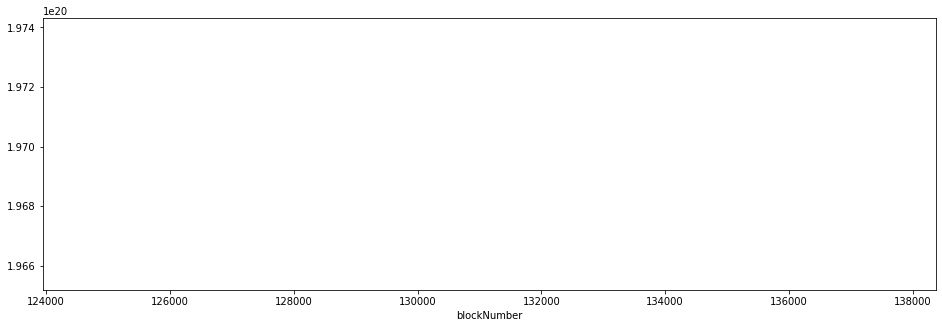

In [17]:
(df_exchange['sellamount']).plot()
(df_exchange['buyamount']).plot()

exchanger     0
buyamount     0
sellamount    0
soldgold      0
dtype: int64


exchanger     1
buyamount     1
sellamount    1
soldgold      1
dtype: int64

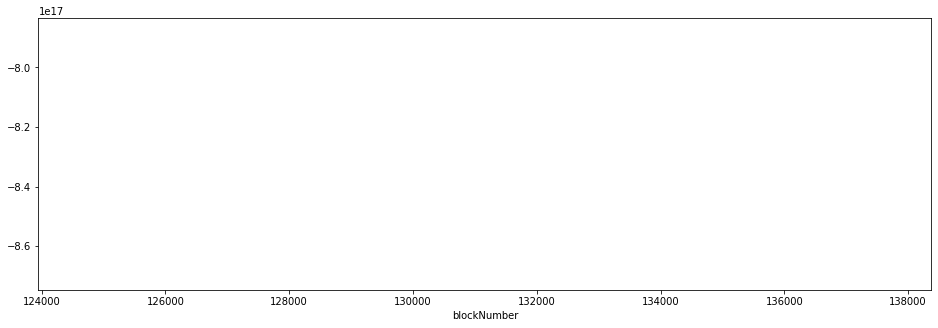

In [18]:
# difference
(df_exchange['buyamount']-df_exchange['sellamount']).plot()
print(df_exchange[df_exchange.soldgold].count())
df_exchange[df_exchange.soldgold == False].count()


In [19]:
df_ex = df_events.set_index('blockNumber')[['buyamount', 'sellamount', 'currentStableBucket', 'currentGoldBucket', 'soldgold']]
df_ex = df_ex[df_ex.buyamount.notna()]

Text(0, 0.5, 'currentGoldBucket')

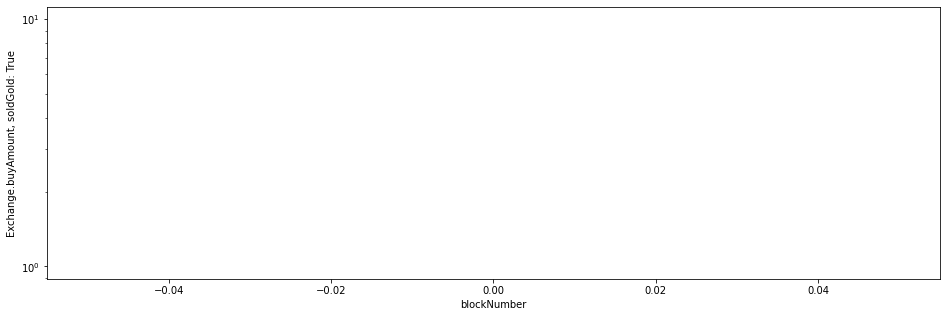

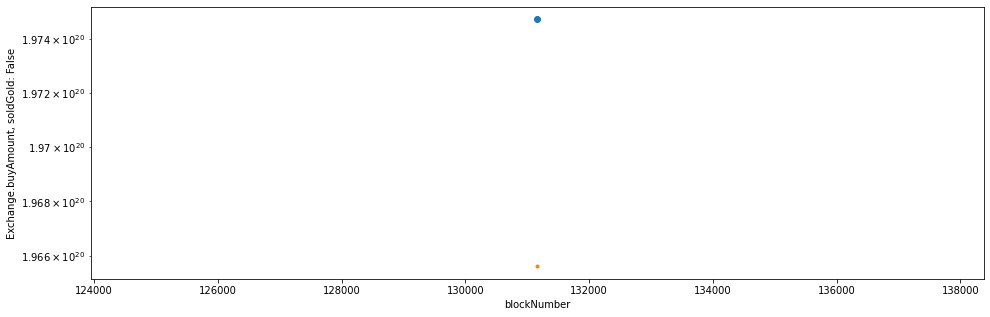

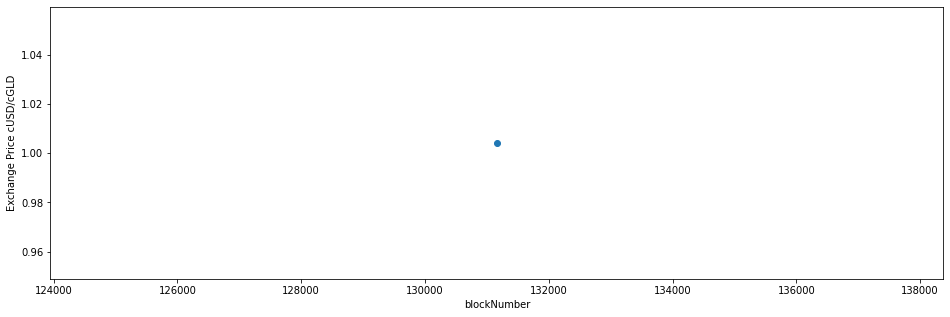

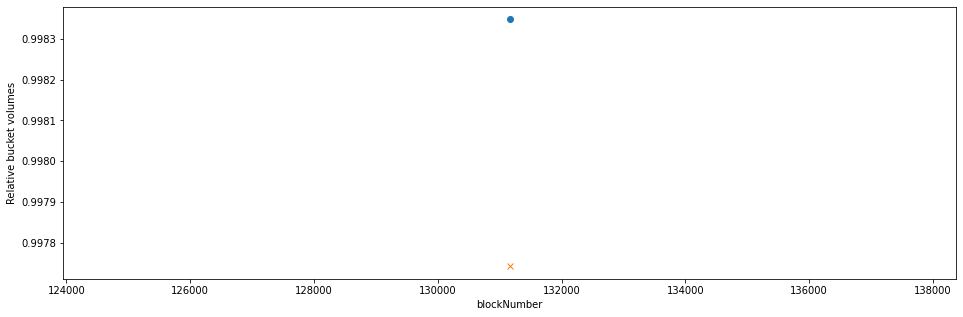

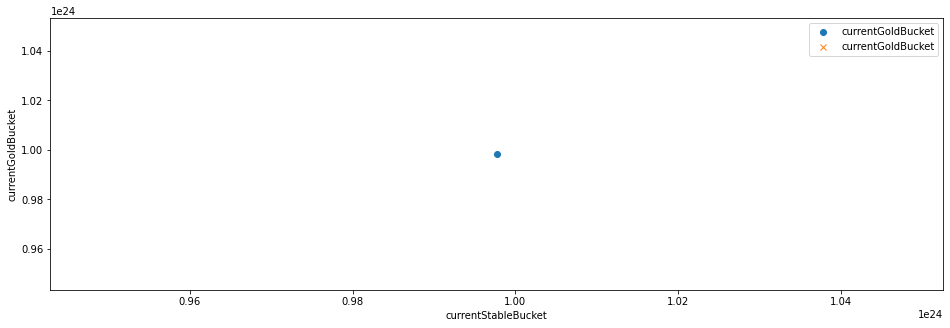

In [20]:
def estimate_buyamount(soldGold):
    df_buy = df_ex[df_ex.soldgold == soldGold]
    Ab = df_buy.buyamount
    As = df_buy.sellamount
    Bs = df_buy.currentStableBucket
    Bg = df_buy.currentGoldBucket
    Bbuy = Bs if soldGold else Bg
    Bsell = Bg if soldGold else Bs

    # buyamount computation is
    # Asell = (1-spread)*As
    # Abuy = Asell/(Bsell+Asell)*Bbuy
    spread = 0
    Asell = (1-spread)*As
    Abuy_hat = Asell/(Bsell+Asell)*Bbuy
    # Abuy_hat = Asell/(Bsell)*Bbuy
    
    return df_buy, Abuy_hat, Bbuy, Bsell


soldGold = True
df_buy_sellgold, Abuy_hat_sellgold, Bbuy_sellgold, Bsell_sellgold = estimate_buyamount(soldGold)
ax = Abuy_hat_sellgold.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellgold.buyamount.plot(marker='.')
(df_buy_sellgold.buyamount - Abuy_hat_sellgold).plot(marker='x', logy=True)

soldGold = False
df_buy_sellusd, Abuy_hat_sellusd, Bbuy_sellusd, Bsell_sellusd = estimate_buyamount(False)
plt.figure()
ax = Abuy_hat_sellusd.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellusd.buyamount.plot(marker='.')
(df_buy_sellusd.buyamount - Abuy_hat_sellusd).plot(marker='x', logy=True)

plt.figure()
ax = (df_buy_sellusd.sellamount/df_buy_sellusd.buyamount).plot(marker='o')
(df_buy_sellgold.buyamount/df_buy_sellgold.sellamount).plot(marker='x')
ax.set_ylabel(f"Exchange Price cUSD/cGLD")

plt.figure()
ax = (df_buy_sellusd.currentGoldBucket/1e24).plot(marker='o')
(df_buy_sellusd.currentStableBucket/1e24).plot(marker='x')
ax.set_ylabel(f"Relative bucket volumes")

fig, ax = plt.subplots(1, 1)
df_buy_sellusd.plot(x='currentStableBucket', y='currentGoldBucket', style='o', ax=ax)
df_buy_sellgold.plot(x='currentStableBucket', y='currentGoldBucket', style='x', ax=ax)
ax.set_ylabel(f"currentGoldBucket")

In [21]:
df_goldlocked = df_events[df_events.eventName == "GoldLocked"].set_index('blockNumber')[['account', 'value']]
df_goldlocked[['value']] = df_goldlocked[['value']].astype('float')
df_goldlocked.groupby('account').value.sum().sort_values(ascending=False)
df_goldlocked[df_goldlocked.account == "0x775a5C899Fd4A7CDD54e9f41738087748CfcB953"].groupby('account').value.sum().sort_values(ascending=False)

Series([], Name: value, dtype: float64)

In [22]:
query_receipt=f"""
WITH logQuery AS (
  SELECT 
    T.jsonPayload.blockNumber as blockNumber,
    T.jsonPayload.from,
    log
  FROM 
    `{table_path}` as T
  CROSS JOIN UNNEST(T.jsonPayload.logs) as log
  WHERE 
    T.jsonPayload.event='{EventTypes.RECEIVED_TRANSACTION_RECEIPT.value}' and
    T.jsonPayload.blockNumber >= {window_min} and
    T.jsonPayload.blockNumber <= {window_max}
ORDER BY blockNumber DESC)
SELECT
  l.blockNumber,
  l.from,
  l.log.address,
  topic
FROM logQuery as l
CROSS JOIN UNNEST(l.log.topics) as topic;
"""

df_receipt = client.query(
    query_receipt, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
)
df_receipt = df_receipt.to_dataframe()

In [23]:
df_receipt.head()

,blockNumber,from,address,topic
0,131180.0,0x8b7852da535df3d06d6adc1906778afd9481588a,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
1,131180.0,0x8b7852da535df3d06d6adc1906778afd9481588a,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x0000000000000000000000008b7852da535df3d06d6a...
2,131180.0,0x8b7852da535df3d06d6adc1906778afd9481588a,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000a8f41ea062c22daffc61...
3,131180.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
4,131180.0,0xed1ed9a71e313d1bce14ab998e0646f212230a33,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000ed1ed9a71e313d1bce14...


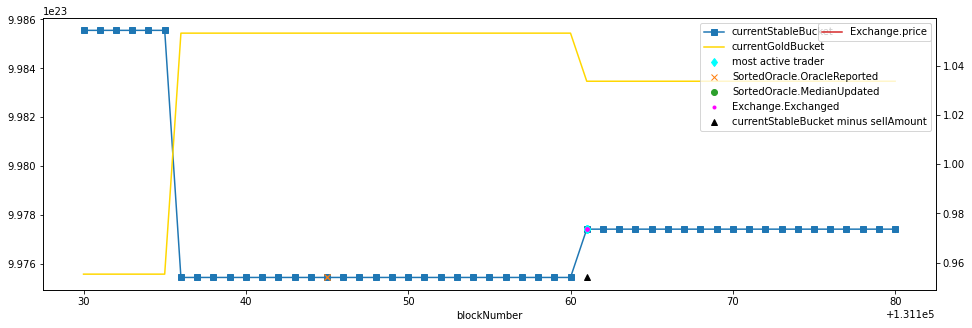

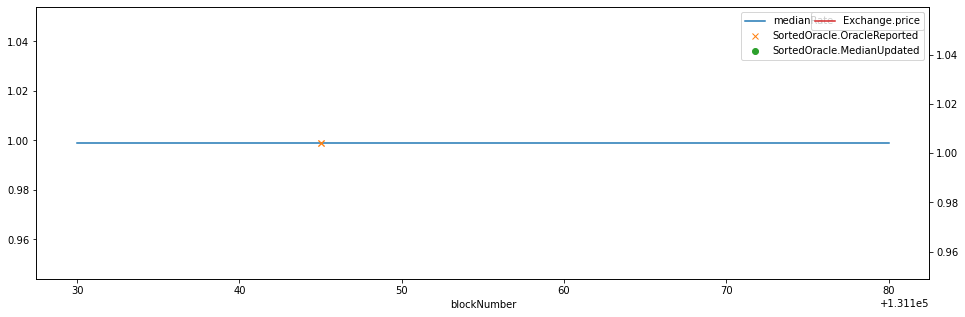

In [24]:
SortedOraclesAddress = '0x91061bF2F509AF76aa01F46E9F3E97577a5a80BA'
OracleReported = '0xdbf09271932e018b9c31e9988e4fbe3109fdd79d78f5d19a764dfb56035ed775'
MedianUpdated = '0x01f3db74cdcb3b158f2144fb78c5ab54e9e8a8c09d3d3b7713050cdb6b6bcb97'
Exchange = '0xC8FD77490A12F46709BffbCC0FCe35740Da8D860'
Exchanged = '0x402ac9185b4616422c2794bf5b118bfcc68ed496d52c0d9841dfa114fdeb05ba'

def filter_event(_df, event, arg='topic'):
    df_event_matches = _df[_df[arg] == event]
    return df_event_matches \
        .merge(df_events, left_on='blockNumber', right_on='blockNumber', suffixes=('_receipt', '')) \
        .merge(df_state, left_on='blockNumber', right_on='blockNumber', suffixes=('', '_state'))

df_report = filter_event(df_receipt, OracleReported)
df_median = filter_event(df_receipt, MedianUpdated)
df_exchanged = filter_event(df_receipt, Exchanged)

df_price = df_buy_sellusd[df_buy_sellusd.index>=window_min]
df_price = df_price[df_price.index<=window_max]
df_price = df_price[df_price.sellamount>0]
price_exchange = df_price.sellamount/df_price.buyamount

df_exchangers = df_exchanged.groupby('from_receipt').count().sort_values(by='blockNumber', ascending=False)
top_exchanger = df_exchangers.index[0] if len(df_exchangers.index) else None

df_active_trader = filter_event(df_receipt, top_exchanger, 'from')
df_active_trader = df_active_trader[df_active_trader.sellamount>0]
fig, ax = plt.subplots()
df_state.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="s")
df_state.set_index('blockNumber').currentGoldBucket.plot(ax=ax, color='gold')
df_active_trader.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="d", linestyle='None', label="most active trader", color="cyan")
df_report.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="x", linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="o", linestyle='None', label="SortedOracle.MedianUpdated")
df_exchanged.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker=".", linestyle='None', label="Exchange.Exchanged", color="magenta")
df_volumes = df_exchanged.set_index('blockNumber')
df_volumes = df_volumes[df_volumes.sellamount>0]
(df_volumes.currentStableBucket - df_volumes.sellamount).plot(ax=ax, marker="^", linestyle='None', color="black", label="currentStableBucket minus sellAmount")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

fig, ax = plt.subplots()
df_state.set_index('blockNumber').medianRate.plot(ax=ax)
df_report.set_index('blockNumber').medianRate.plot(ax=ax, marker="x", linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').medianRate.plot(ax=ax, marker="o", linestyle='None', label="SortedOracle.MedianUpdated")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

In [25]:
df_exchangers.head()

,blockNumber,address_receipt,topic,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,...,medianRate_state,currentStableBucket_state,currentGoldBucket_state,goldTokenTotalSupply_state,timestamp_block_state,gasUsed_state,gasLimit_state,txAmount_state,blocktime_state,datetime_block_state
from_receipt,,,,,,,,,,,,,,,,,,,,,
0x060b52f506579625ad73b99f1be8d6b06259953d,5,5,5,5,5,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
